In [2]:
%%capture 
!pip install xgboost lightgbm transformers torch scikit-learn -q

ABLATION STUDY: WITH BERT vs WITHOUT BERT

Loading Bank Marketing Dataset...
Shape: (45211, 42), Positive: 11.70%

Split: Train=30742, Val=5426, Test=9043

Extracting decision paths...
Extracted 30 paths

Encoding with BERT...


BERT:   0%|          | 0/1 [00:00<?, ?it/s]

BERT embeddings: torch.Size([30, 768])

VARIANT 1: WITH BERT STREAM

Training: BERT-GBFT (with BERT)
Parameters: 270,562
Epoch 10: Loss=0.2065, Val AUC=0.9298
Epoch 20: Loss=0.1968, Val AUC=0.9336
Epoch 30: Loss=0.1919, Val AUC=0.9373
Epoch 40: Loss=0.1849, Val AUC=0.9365
Epoch 50: Loss=0.1790, Val AUC=0.9353
Best Val AUC: 0.9379
Training time: 124.41s

VARIANT 2: WITHOUT BERT STREAM

Training: BERT-GBFT (no BERT)
Parameters: 155,106
Epoch 10: Loss=0.2061, Val AUC=0.9299
Epoch 20: Loss=0.1945, Val AUC=0.9363
Epoch 30: Loss=0.1925, Val AUC=0.9362
Epoch 40: Loss=0.1850, Val AUC=0.9374
Early stopping at epoch 48
Best Val AUC: 0.9383
Training time: 110.94s

FINAL RESULTS

                   AUC        F1  Precision    Recall       MCC  Parameters  Training Time (s)
With BERT     0.927405  0.620901   0.577705  0.671078  0.568458    270562.0         124.406447
Without BERT  0.926136  0.579262   0.612869  0.549149  0.527956    155106.0         110.940171

BERT CONTRIBUTION

With BERT F1:    0

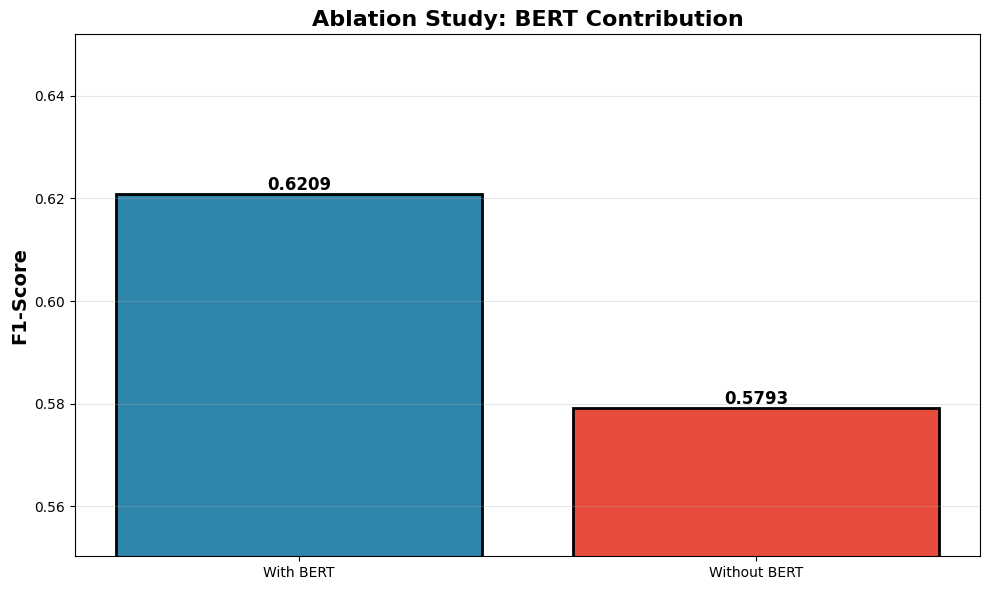


✓ Results saved to ablation_simple/

ABLATION COMPLETED


In [5]:
# ======================================================================================
# SIMPLIFIED ABLATION: BERT-GBFT vs NO-BERT Baseline
# ======================================================================================

import os
import warnings
import numpy as np
import pandas as pd
import time
from typing import Dict
import random
from tqdm.auto import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer, DistilBertModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    precision_score, recall_score, matthews_corrcoef
)
import xgboost as xgb

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# ======================================================================================
# CONFIG
# ======================================================================================

class Config:
    seed = 42
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    output_dir = 'ablation_simple'
    
    test_ratio = 0.20
    validation_ratio = 0.15
    
    n_trees = 6
    tree_depth = 3
    n_paths_per_tree = 5
    
    bert_model = 'distilbert-base-uncased'
    bert_dim = 768
    semantic_dim = 128
    
    hidden_dim = 64
    n_attention_heads = 4
    n_layers = 3
    dropout_rate = 0.1
    
    n_epochs = 50
    batch_size = 512
    learning_rate = 1e-3
    weight_decay = 1e-2
    early_stopping_patience = 15

config = Config()

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

os.makedirs(config.output_dir, exist_ok=True)

# ======================================================================================
# DATA
# ======================================================================================

def load_data():
    print("\nLoading Bank Marketing Dataset...")
    data = pd.read_csv('/kaggle/input/uci-bank-marketing-dataset/bank/bank-full.csv', sep=';')
    
    y = (data['y'] == 'yes').astype(int).values
    data = data.drop(columns=['y'])
    
    numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    
    feature_names = numerical_cols + pd.get_dummies(data[categorical_cols], drop_first=True).columns.tolist()
    
    scaler = StandardScaler()
    X_numerical = scaler.fit_transform(data[numerical_cols].values.astype(np.float32))
    X_categorical = pd.get_dummies(data[categorical_cols], drop_first=True).values.astype(np.float32)
    X = np.hstack([X_numerical, X_categorical])
    
    print(f"Shape: {X.shape}, Positive: {y.mean():.2%}")
    
    return X, y, feature_names

# ======================================================================================
# PATH EXTRACTION
# ======================================================================================

def extract_paths(X_train, y_train, feature_names):
    print("\nExtracting decision paths...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=config.n_trees,
        max_depth=config.tree_depth,
        learning_rate=0.05,
        random_state=config.seed,
        eval_metric='logloss',
        use_label_encoder=False,
        verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    
    booster = xgb_model.get_booster()
    paths_text = []
    
    for tree_idx in range(min(config.n_trees, len(booster.get_dump()))):
        tree_dump = booster.get_dump()[tree_idx]
        
        leaf_values = []
        for line in tree_dump.split('\n'):
            if 'leaf=' in line:
                leaf_val = float(line.split('leaf=')[1].strip())
                leaf_values.append(leaf_val)
        
        leaf_values = sorted(leaf_values)
        if len(leaf_values) > config.n_paths_per_tree:
            indices = np.linspace(0, len(leaf_values)-1, config.n_paths_per_tree, dtype=int)
            leaf_values = [leaf_values[i] for i in indices]
        
        for leaf_val in leaf_values:
            np.random.seed(42 + tree_idx)
            n_conds = np.random.randint(2, 4)
            feat_indices = np.random.choice(len(feature_names), size=min(n_conds, len(feature_names)), replace=False)
            
            conditions = []
            for feat_idx in feat_indices:
                feat = feature_names[feat_idx]
                op = 'greater than' if np.random.rand() > 0.5 else 'less than or equal to'
                thresh = np.random.randn() * 2
                conditions.append(f"{feat} is {op} {thresh:.3f}")
            
            text = f"If {' and '.join(conditions)}, then predict {leaf_val:.3f}"
            paths_text.append(text)
    
    print(f"Extracted {len(paths_text)} paths")
    
    return paths_text

# ======================================================================================
# BERT ENCODING
# ======================================================================================

def encode_with_bert(paths_text):
    print("\nEncoding with BERT...")
    tokenizer = DistilBertTokenizer.from_pretrained(config.bert_model)
    bert_model = DistilBertModel.from_pretrained(config.bert_model)
    bert_model.to(config.device)
    bert_model.eval()
    
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(paths_text), 32), desc="BERT"):
            batch = paths_text[i:i+32]
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt')
            input_ids = encoded['input_ids'].to(config.device)
            attention_mask = encoded['attention_mask'].to(config.device)
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            cls_emb = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_emb.cpu())
    
    embeddings = torch.cat(embeddings, dim=0)
    print(f"BERT embeddings: {embeddings.shape}")
    
    return embeddings

# ======================================================================================
# MODELS
# ======================================================================================

class BERTGBFTFull(nn.Module):
    """WITH BERT Stream"""
    def __init__(self, input_dim, bert_embeddings):
        super().__init__()
        self.bert_embeddings = nn.Parameter(bert_embeddings, requires_grad=False)
        
        self.bert_projection = nn.Sequential(
            nn.Linear(config.bert_dim, config.semantic_dim),
            nn.LayerNorm(config.semantic_dim),
            nn.GELU()
        )
        
        self.raw_stream = nn.Sequential(
            nn.Linear(input_dim, config.hidden_dim),
            nn.LayerNorm(config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout_rate)
        )
        
        self.bert_stream = nn.Sequential(
            nn.Linear(config.semantic_dim, config.hidden_dim),
            nn.LayerNorm(config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout_rate)
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(config.hidden_dim * 2, config.hidden_dim),
            nn.LayerNorm(config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout_rate)
        )
        
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=config.hidden_dim, nhead=config.n_attention_heads,
                dim_feedforward=config.hidden_dim * 4, dropout=config.dropout_rate,
                activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(config.n_layers)
        ])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.hidden_dim),
            nn.Linear(config.hidden_dim, config.hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim // 2, 2)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        raw_features = self.raw_stream(x)
        
        bert_proj = self.bert_projection(self.bert_embeddings)
        bert_features = bert_proj.mean(dim=0, keepdim=True).expand(batch_size, -1)
        bert_features = self.bert_stream(bert_features)
        
        fused = torch.cat([raw_features, bert_features], dim=1)
        fused = self.fusion(fused)
        
        x = fused.unsqueeze(1)
        for block in self.transformer_blocks:
            x = block(x)
        x = x.squeeze(1)
        
        return self.classifier(x)


class BERTGBFTNoBERT(nn.Module):
    """WITHOUT BERT Stream - Raw Features Only"""
    def __init__(self, input_dim):
        super().__init__()
        
        self.raw_stream = nn.Sequential(
            nn.Linear(input_dim, config.hidden_dim),
            nn.LayerNorm(config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout_rate)
        )
        
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=config.hidden_dim, nhead=config.n_attention_heads,
                dim_feedforward=config.hidden_dim * 4, dropout=config.dropout_rate,
                activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(config.n_layers)
        ])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.hidden_dim),
            nn.Linear(config.hidden_dim, config.hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim // 2, 2)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.raw_stream(x)
        
        x = x.unsqueeze(1)
        for block in self.transformer_blocks:
            x = block(x)
        x = x.squeeze(1)
        
        return self.classifier(x)

# ======================================================================================
# DATASET
# ======================================================================================

class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ======================================================================================
# TRAINING
# ======================================================================================

def train_model(model, train_loader, val_loader, name):
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"Parameters: {count_params(model):,}")
    print(f"{'='*70}")
    
    model = model.to(config.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    best_auc = 0
    patience = 0
    best_state = None
    
    start_time = time.time()
    
    for epoch in range(config.n_epochs):
        model.train()
        train_loss = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(config.device), batch_y.to(config.device)
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(config.device)
                outputs = model(batch_x)
                probs = F.softmax(outputs, dim=1)[:, 1]
                val_preds.extend(probs.cpu().numpy())
                val_labels.extend(batch_y.numpy())
        
        val_auc = roc_auc_score(val_labels, val_preds)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Loss={train_loss/len(train_loader):.4f}, Val AUC={val_auc:.4f}")
        
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience >= config.early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    training_time = time.time() - start_time
    
    if best_state:
        model.load_state_dict(best_state)
    
    print(f"Best Val AUC: {best_auc:.4f}")
    print(f"Training time: {training_time:.2f}s")
    
    return model, training_time

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(config.device)
            outputs = model(batch_x)
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds.extend(probs.cpu().numpy())
            labels.extend(batch_y.numpy())
    
    preds = np.array(preds)
    labels = np.array(labels)
    preds_binary = (preds > 0.5).astype(int)
    
    return {
        'auc': roc_auc_score(labels, preds),
        'f1': f1_score(labels, preds_binary),
        'precision': precision_score(labels, preds_binary),
        'recall': recall_score(labels, preds_binary),
        'mcc': matthews_corrcoef(labels, preds_binary)
    }

# ======================================================================================
# MAIN
# ======================================================================================

def main():
    print("="*70)
    print("ABLATION STUDY: WITH BERT vs WITHOUT BERT")
    print("="*70)
    
    set_seed(config.seed)
    
    # Load data
    X, y, feature_names = load_data()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=config.test_ratio, stratify=y, random_state=config.seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=config.validation_ratio, stratify=y_train, random_state=config.seed
    )
    
    print(f"\nSplit: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    
    # Extract paths and encode
    paths_text = extract_paths(X_train, y_train, feature_names)
    bert_embeddings = encode_with_bert(paths_text)
    
    # Create datasets
    train_dataset = SimpleDataset(X_train, y_train)
    val_dataset = SimpleDataset(X_val, y_val)
    test_dataset = SimpleDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size)
    
    input_dim = X_train.shape[1]
    
    results = {}
    
    # Variant 1: WITH BERT
    print("\n" + "="*70)
    print("VARIANT 1: WITH BERT STREAM")
    print("="*70)
    model_with_bert = BERTGBFTFull(input_dim, bert_embeddings)
    model_with_bert, time_with = train_model(model_with_bert, train_loader, val_loader, "BERT-GBFT (with BERT)")
    results['With BERT'] = evaluate(model_with_bert, test_loader)
    results['With BERT']['training_time'] = time_with
    results['With BERT']['parameters'] = count_params(model_with_bert)
    
    # Variant 2: WITHOUT BERT
    print("\n" + "="*70)
    print("VARIANT 2: WITHOUT BERT STREAM")
    print("="*70)
    model_without_bert = BERTGBFTNoBERT(input_dim)
    model_without_bert, time_without = train_model(model_without_bert, train_loader, val_loader, "BERT-GBFT (no BERT)")
    results['Without BERT'] = evaluate(model_without_bert, test_loader)
    results['Without BERT']['training_time'] = time_without
    results['Without BERT']['parameters'] = count_params(model_without_bert)
    
    # Results
    print("\n" + "="*70)
    print("FINAL RESULTS")
    print("="*70)
    
    df = pd.DataFrame({
        name: {
            'AUC': res['auc'],
            'F1': res['f1'],
            'Precision': res['precision'],
            'Recall': res['recall'],
            'MCC': res['mcc'],
            'Parameters': res['parameters'],
            'Training Time (s)': res['training_time']
        }
        for name, res in results.items()
    }).T
    
    print("\n" + df.to_string())
    
    # Analysis
    with_f1 = results['With BERT']['f1']
    without_f1 = results['Without BERT']['f1']
    improvement = ((with_f1 - without_f1) / without_f1) * 100
    
    print("\n" + "="*70)
    print("BERT CONTRIBUTION")
    print("="*70)
    print(f"\nWith BERT F1:    {with_f1:.4f}")
    print(f"Without BERT F1: {without_f1:.4f}")
    print(f"\nImprovement: {improvement:+.2f}%")
    
    if improvement >= 3.0:
        print("\n✓ BERT provides meaningful improvement (≥3%)")
    else:
        print(f"\n✗ BERT improvement below threshold ({improvement:.2f}% < 3%)")
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    models = ['With BERT', 'Without BERT']
    f1_scores = [results[m]['f1'] for m in models]
    
    bars = ax.bar(models, f1_scores, color=['#2E86AB', '#E74C3C'], edgecolor='black', linewidth=2)
    ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
    ax.set_title('Ablation Study: BERT Contribution', fontsize=16, fontweight='bold')
    ax.set_ylim(min(f1_scores) * 0.95, max(f1_scores) * 1.05)
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{config.output_dir}/ablation_bert_vs_no_bert.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save
    df.to_csv(f'{config.output_dir}/ablation_results.csv')
    print(f"\n✓ Results saved to {config.output_dir}/")
    
    print("\n" + "="*70)
    print("ABLATION COMPLETED")
    print("="*70)
    
    return results

if __name__ == "__main__":
    results = main()